# The dataset

This is a dataset from [Kaggle](https://www.kaggle.com/c/forest-cover-type-prediction), looking at the prediction of the forest cover based on different features. They are 7 type of cover types.

The features (from Kaggle):
 - Elevation - Elevation in meters
 - Aspect - Aspect in degrees azimuth
 - Slope - Slope in degrees
 - Horizontal_Distance_To_Hydrology - Horz Dist to nearest surface water features
 - Vertical_Distance_To_Hydrology - Vert Dist to nearest surface water features
 - Horizontal_Distance_To_Roadways - Horz Dist to nearest roadway
 - Hillshade_9am (0 to 255 index) - Hillshade index at 9am, summer solstice
 - Hillshade_Noon (0 to 255 index) - Hillshade index at noon, summer solstice
 - Hillshade_3pm (0 to 255 index) - Hillshade index at 3pm, summer solstice
 - Horizontal_Distance_To_Fire_Points - Horz Dist to nearest wildfire ignition points
 - Wilderness_Area (4 binary columns, 0 = absence or 1 = presence) - Wilderness area designation
 - Soil_Type (40 binary columns, 0 = absence or 1 = presence) - Soil Type designation


In [16]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

import os
plt.rcParams['figure.figsize'] = (20.0, 10.0)
import warnings
warnings.filterwarnings(action="ignore")

In [3]:
with open("forest_cover.csv", 'rt') as f:
    train = pd.read_csv(f)

In [4]:
covert = {1:"Spruce",2:"Lodgepole Pine",3:"Ponderosa Pine",4:"Willow",5:"Aspen",6:"Douglas-fir",7:"Krummholz"}
train["Cover"] = train.Cover_Type.apply(lambda x:covert.get(x))

In [5]:
train["Soil"]= train[[col for col in train.columns if "Soil_" in col]].idxmax(1)
train["Wilderness"]= train[[col for col in train.columns if "Wilderness_" in col]].idxmax(1)
train["Cover"] = pd.Categorical(train.Cover)

# Elevation and Cover Type

The cover changes when the elevation changes.

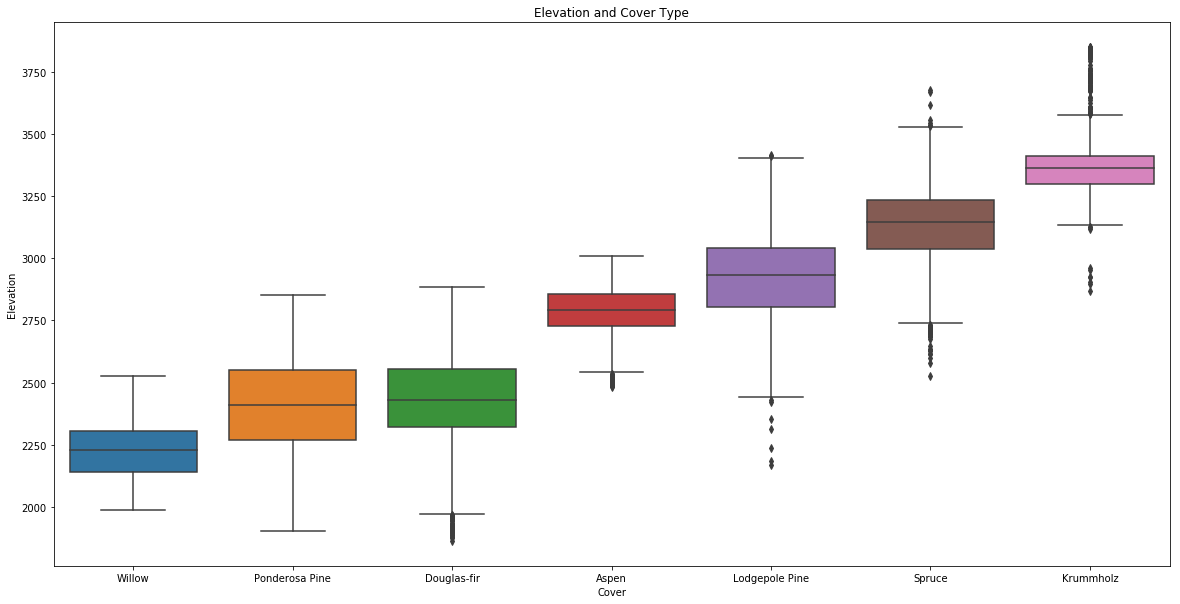

In [9]:
order_label = [covert[i] for i in [4,3,6,5,2,1,7]]
sns.boxplot(x="Cover", y="Elevation", data=train,order=order_label)
plt.title("Elevation and Cover Type");

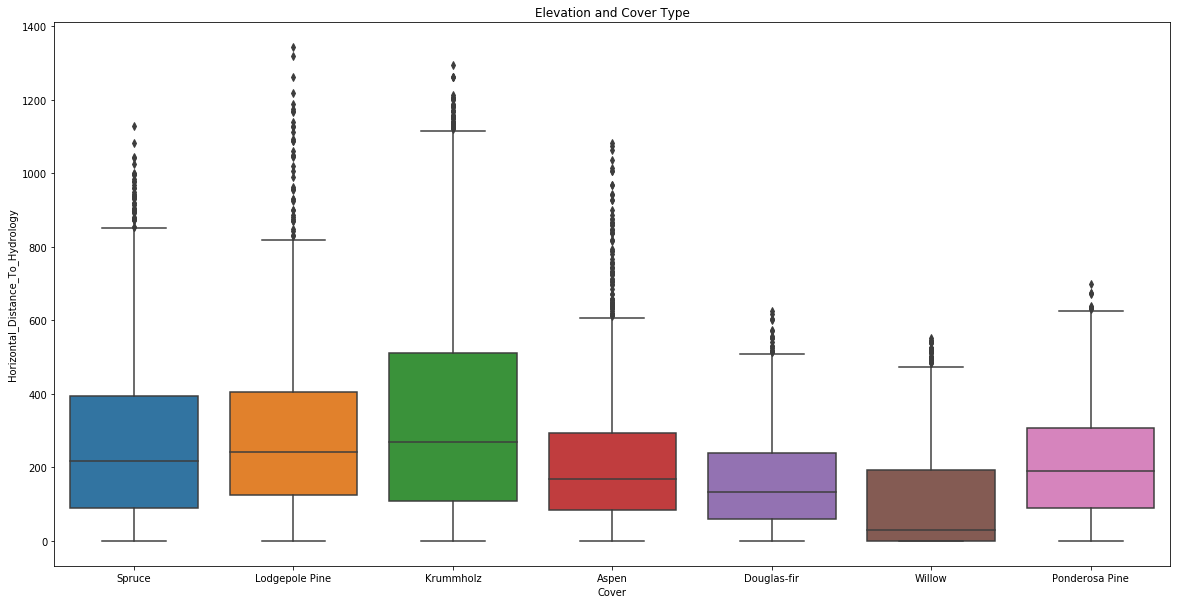

In [10]:
order_label = [covert[i] for i in [1,2,7,5,6,4,3]]
sns.boxplot(x="Cover", y="Horizontal_Distance_To_Hydrology", data=train,order=order_label)
plt.title("Elevation and Cover Type");

# PCA.

In [11]:
for_pca = train[['Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']].copy()
corr = for_pca.corr()

In [12]:
cmap = sns.diverging_palette(128, 240,as_cmap=True)
plt.rcParams.update({'font.size': 12})


# Initial correlation matrix

We notice there are a few high correlations, initially we will focus on the distance variables (correlated with *Elevation* 

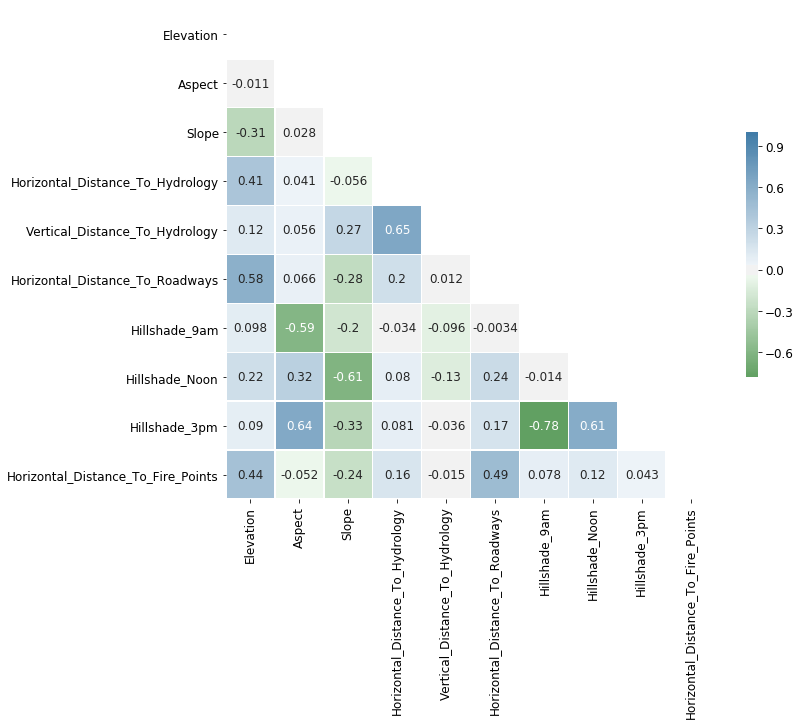

In [13]:
corr = for_pca.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [14]:
for_pca["distance_to_hydrology"] = np.sqrt(train.Horizontal_Distance_To_Hydrology**2 + train.Vertical_Distance_To_Hydrology**2)
angles_col = []
for col in ["Aspect","Slope"]:
    for_pca["sin_"+col] = np.sin(np.radians(for_pca[col]))
    for_pca["cos_"+col] = np.cos(np.radians(for_pca[col]))

for op_1 in ["sin","cos"]:
    for op_2 in ["sin","cos"]:
        for_pca[f"combine_{op_1}_{op_2}"] = for_pca[op_1+"_Aspect"]*for_pca[op_2+"_Slope"]


# Variables

First we want to check the distribution of the variables to make sure they are close to a normal dsitribution.

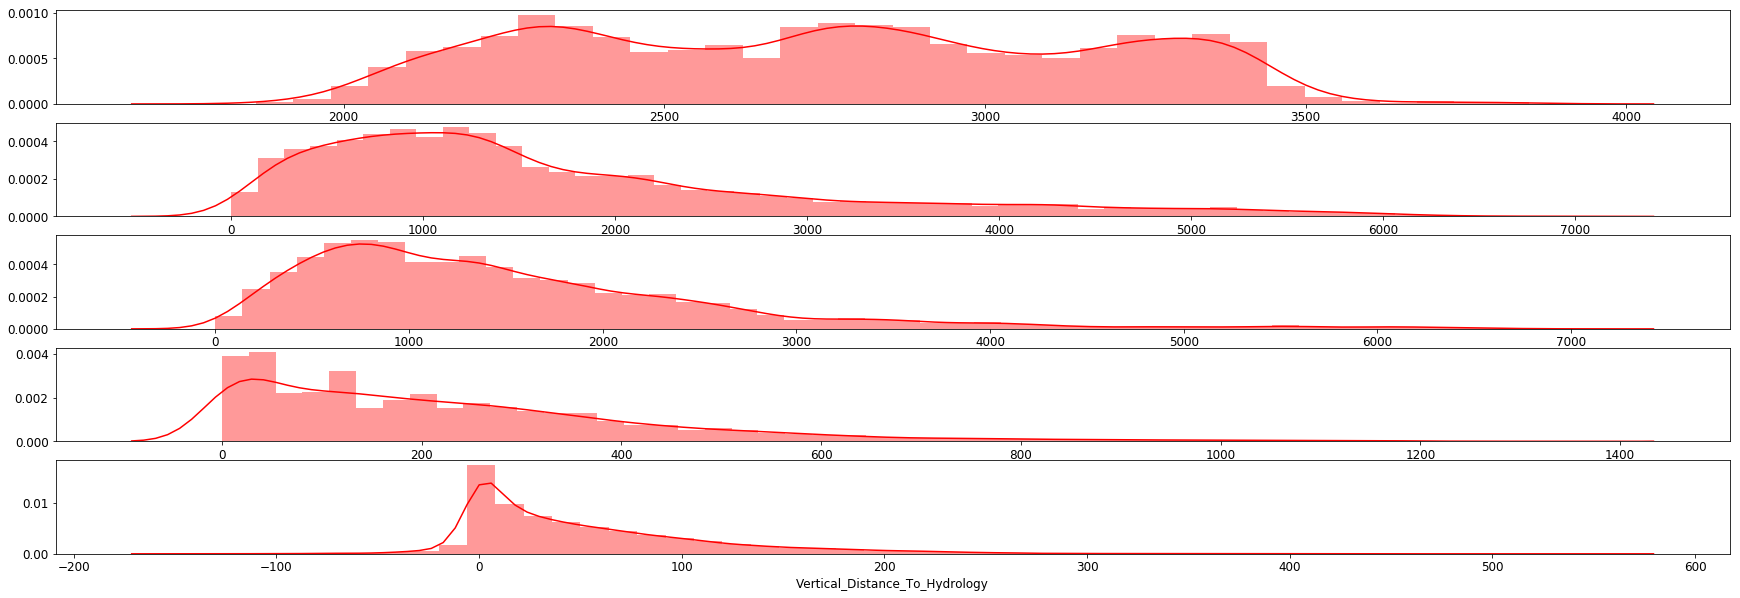

In [18]:
to_see = ["Elevation","Horizontal_Distance_To_Roadways"
                       ,"Horizontal_Distance_To_Fire_Points"
                       ,"Horizontal_Distance_To_Hydrology"
                       ,"Vertical_Distance_To_Hydrology"]

f, axes = plt.subplots(len(to_see), 1, figsize=(30, 10))

for i,col in enumerate(to_see):
    sns.distplot(for_pca[col], hist=True, color="r",ax=axes[i])
    axes[i].set_title("")

# Changing the variable

The last distance variable seem to have a very long tail (a lot of values around 0 and then very few very large values).

To reduce the influence of the tail, we will use a log10 of those variables.

In [19]:
for col in ["Horizontal_Distance_To_Roadways"
                       ,"Horizontal_Distance_To_Fire_Points"
                       ,"Horizontal_Distance_To_Hydrology"
                       ,"distance_to_hydrology"]:
    for_pca[col+"_log"] = np.log10(pd.to_numeric(for_pca[col]) +1)

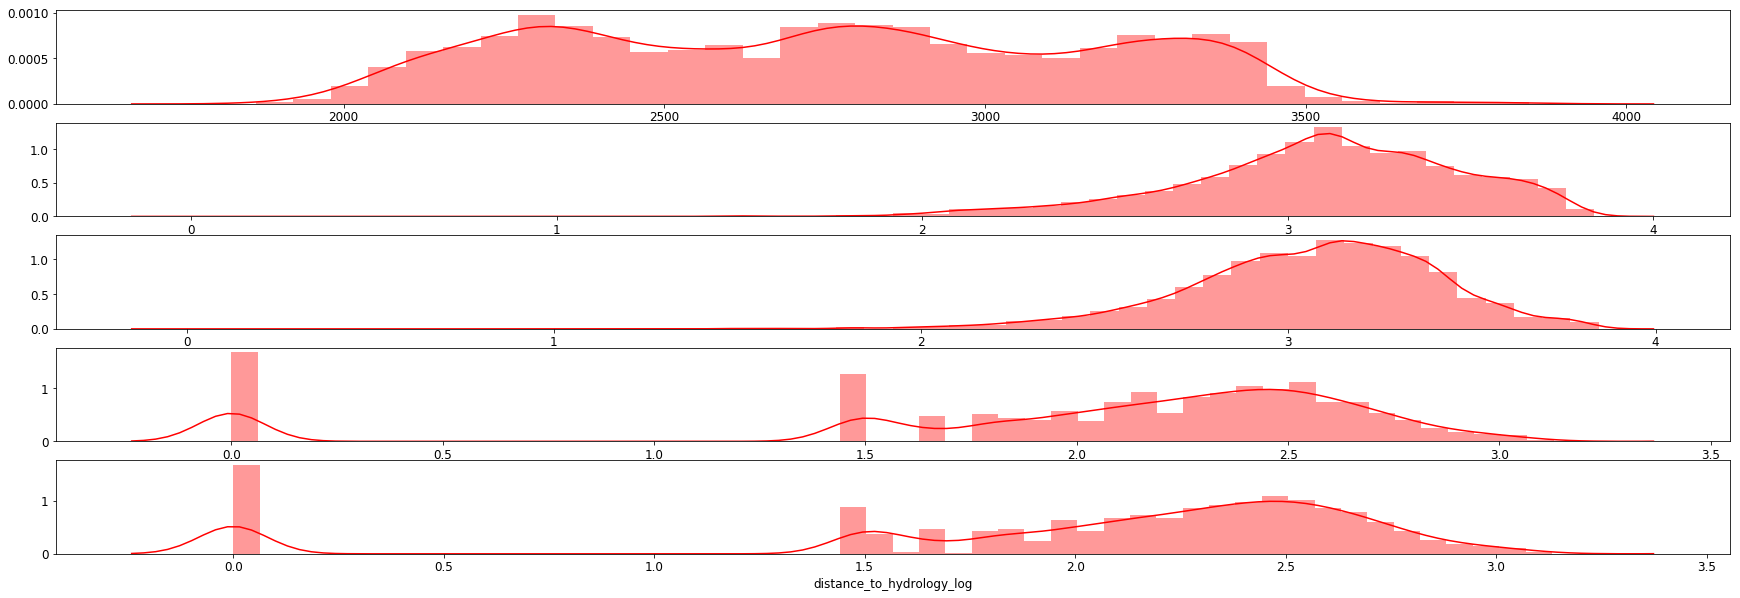

In [20]:
to_see = ["Elevation","Horizontal_Distance_To_Roadways_log"
                       ,"Horizontal_Distance_To_Fire_Points_log"
                       ,"Horizontal_Distance_To_Hydrology_log"
                       ,"distance_to_hydrology_log"]

f, axes = plt.subplots(len(to_see), 1,  figsize=(30, 10))

#sns.distplot(train.Elevation, kde=False, color="b", ax=axes[0]);
for i,col in enumerate(to_see):
    sns.distplot(for_pca[col], hist=True, color="r",ax=axes[i])
    axes[i].set_title("")

In [21]:
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 

In [22]:
distance_pca = for_pca[["Elevation","Horizontal_Distance_To_Roadways_log"
                       ,"Horizontal_Distance_To_Fire_Points_log"
                       ,"Horizontal_Distance_To_Hydrology_log"
                       ,"distance_to_hydrology_log"
                       ,"Vertical_Distance_To_Hydrology"]]

In [23]:
sklearn_pca = PCA(n_components=2)
X = StandardScaler().fit_transform(distance_pca)
Y_sklearn = sklearn_pca.fit_transform(X)

In [24]:
sklearn_pca.components_

array([[-0.39392485, -0.25435672, -0.26671268, -0.54007271, -0.53883225,
        -0.3563306 ],
       [-0.43182911, -0.53909151, -0.47923846,  0.27803419,  0.28707694,
         0.36540154]])

In [25]:
for_pca["dis_pca_1"] = Y_sklearn[:,0]
for_pca["dis_pca_2"] = Y_sklearn[:,1]

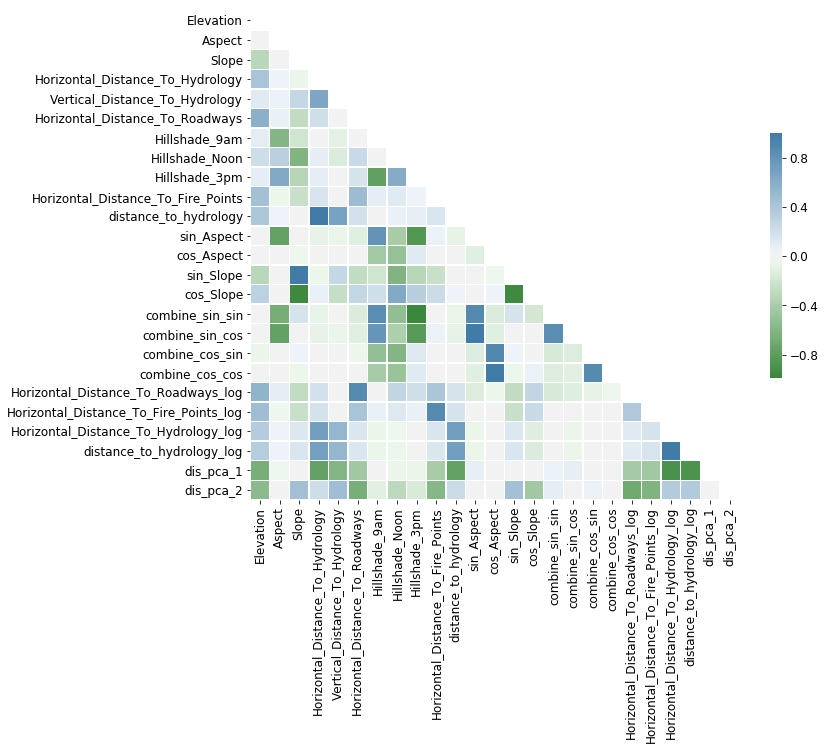

In [26]:
corr = for_pca.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

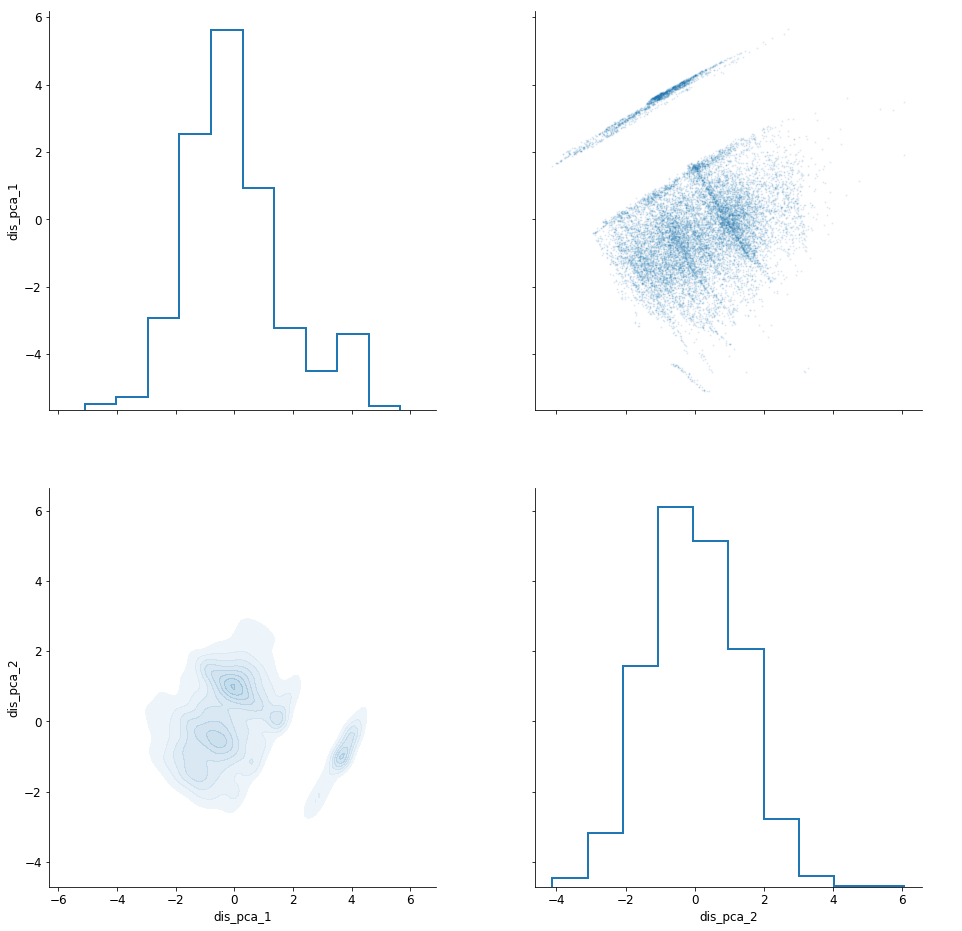

In [27]:
g = sns.PairGrid(for_pca, vars=["dis_pca_1","dis_pca_2"]
                 ,diag_sharey=False)
g.map_upper(plt.scatter,alpha=0.1, s=1)

g.map_lower(sns.kdeplot,alpha=0.3,shade=True, shade_lowest=False)
g = g.map_diag(plt.hist, histtype="step", linewidth=2)

g.add_legend();
g.fig.set_size_inches(15,15)

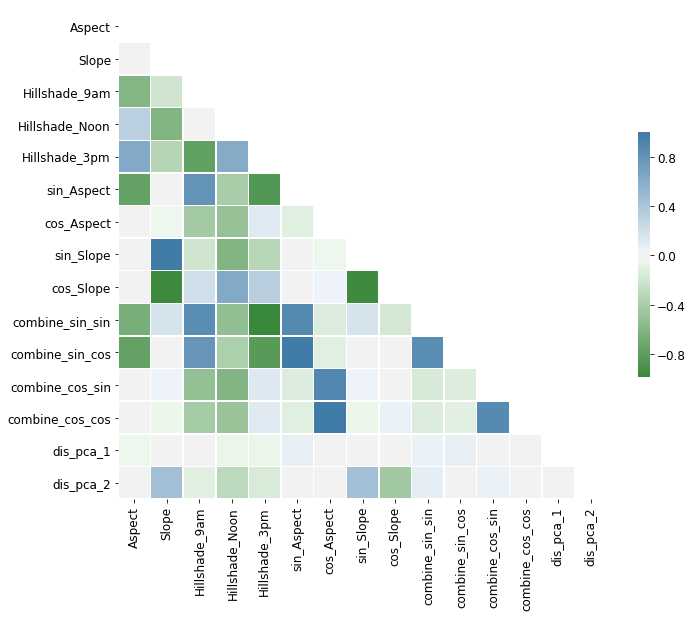

In [28]:
for_pca_after_distance = for_pca.drop(["Elevation","Horizontal_Distance_To_Roadways"
                       ,"Horizontal_Distance_To_Fire_Points"
                       ,"Horizontal_Distance_To_Hydrology"
                       ,"Vertical_Distance_To_Hydrology"
                       ,"distance_to_hydrology"
                        ,"Horizontal_Distance_To_Roadways_log"
                       ,"Horizontal_Distance_To_Fire_Points_log"
                       ,"Horizontal_Distance_To_Hydrology_log"
                       ,"distance_to_hydrology_log"],axis=1)
corr = for_pca_after_distance.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [29]:
for_pca_after_distance.columns

Index(['Aspect', 'Slope', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'sin_Aspect', 'cos_Aspect', 'sin_Slope', 'cos_Slope', 'combine_sin_sin',
       'combine_sin_cos', 'combine_cos_sin', 'combine_cos_cos', 'dis_pca_1',
       'dis_pca_2'],
      dtype='object')

In [30]:
trigo_pca = for_pca[['sin_Aspect', 'sin_Slope',
       'combine_sin_sin', 'cos_Aspect', 'cos_Slope',
       'combine_sin_cos',  'combine_cos_sin',
       'combine_cos_cos', ]]
sklearn_pca = PCA(n_components=1)
X = StandardScaler().fit_transform(trigo_pca)
Y_sklearn = sklearn_pca.fit_transform(X)

In [31]:
for_pca["trig_pca_1"] = Y_sklearn[:,0]


In [32]:
sklearn_pca.components_

array([[ 0.40878743,  0.08319948,  0.40771009, -0.40976166, -0.08529235,
         0.40280113, -0.39673334, -0.40610056]])

In [33]:
for_pca.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'distance_to_hydrology',
       'sin_Aspect', 'cos_Aspect', 'sin_Slope', 'cos_Slope', 'combine_sin_sin',
       'combine_sin_cos', 'combine_cos_sin', 'combine_cos_cos',
       'Horizontal_Distance_To_Roadways_log',
       'Horizontal_Distance_To_Fire_Points_log',
       'Horizontal_Distance_To_Hydrology_log', 'distance_to_hydrology_log',
       'dis_pca_1', 'dis_pca_2', 'trig_pca_1'],
      dtype='object')

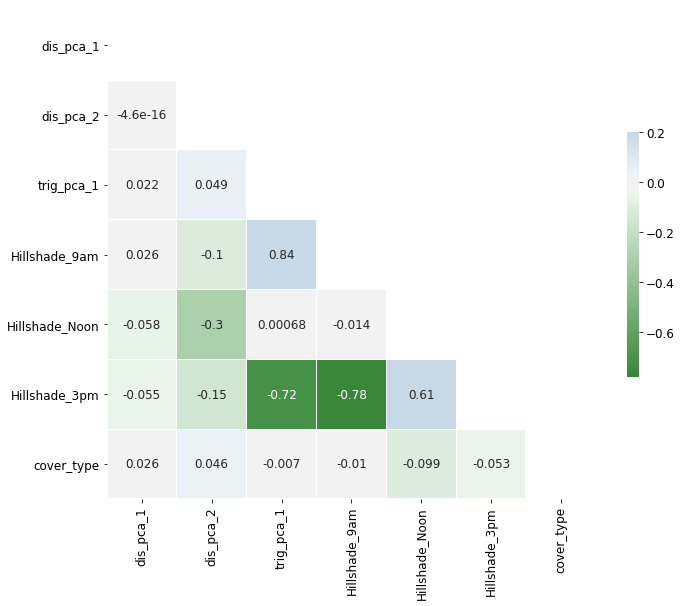

In [34]:
after_pca = for_pca[['dis_pca_1','dis_pca_2', 'trig_pca_1','Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']].copy()
after_pca["cover_type"] = train.Cover_Type
after_pca["cover"] = train.Cover
corr = after_pca.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr,  mask=mask,cmap=cmap, center=0, vmax=0.2,annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [35]:
shade_pca = for_pca[['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',"Aspect","Slope","trig_pca_1"]]
sklearn_pca = PCA(n_components=2)
X = StandardScaler().fit_transform(shade_pca)
Y_sklearn = sklearn_pca.fit_transform(X)
for_pca["shade_pca_1"] = Y_sklearn[:,0]
for_pca["shade_pca_2"] = Y_sklearn[:,1]


In [36]:
sklearn_pca.components_

array([[ 0.47581138, -0.25499793, -0.53786064, -0.42862538,  0.13465654,
         0.46629756],
       [-0.36160836, -0.61630984, -0.12911032,  0.08801271,  0.64466821,
        -0.22223584]])

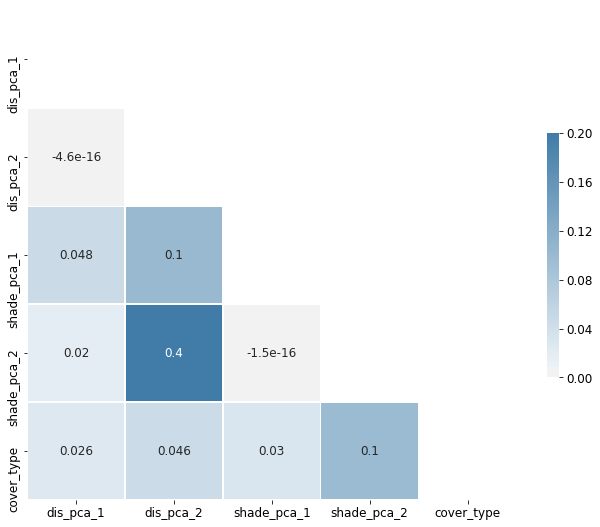

In [37]:
after_pca = for_pca[['dis_pca_1','dis_pca_2','shade_pca_1','shade_pca_2']].copy()
after_pca["cover_type"] = train.Cover_Type
after_pca["cover"] = train.Cover
corr = after_pca.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr,  mask=mask,cmap=cmap, center=0, vmax=0.2,annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [38]:
import scipy

scipy.stats.pearsonr(after_pca.shade_pca_2,after_pca.dis_pca_2)

(0.39869637842773475, 0.0)

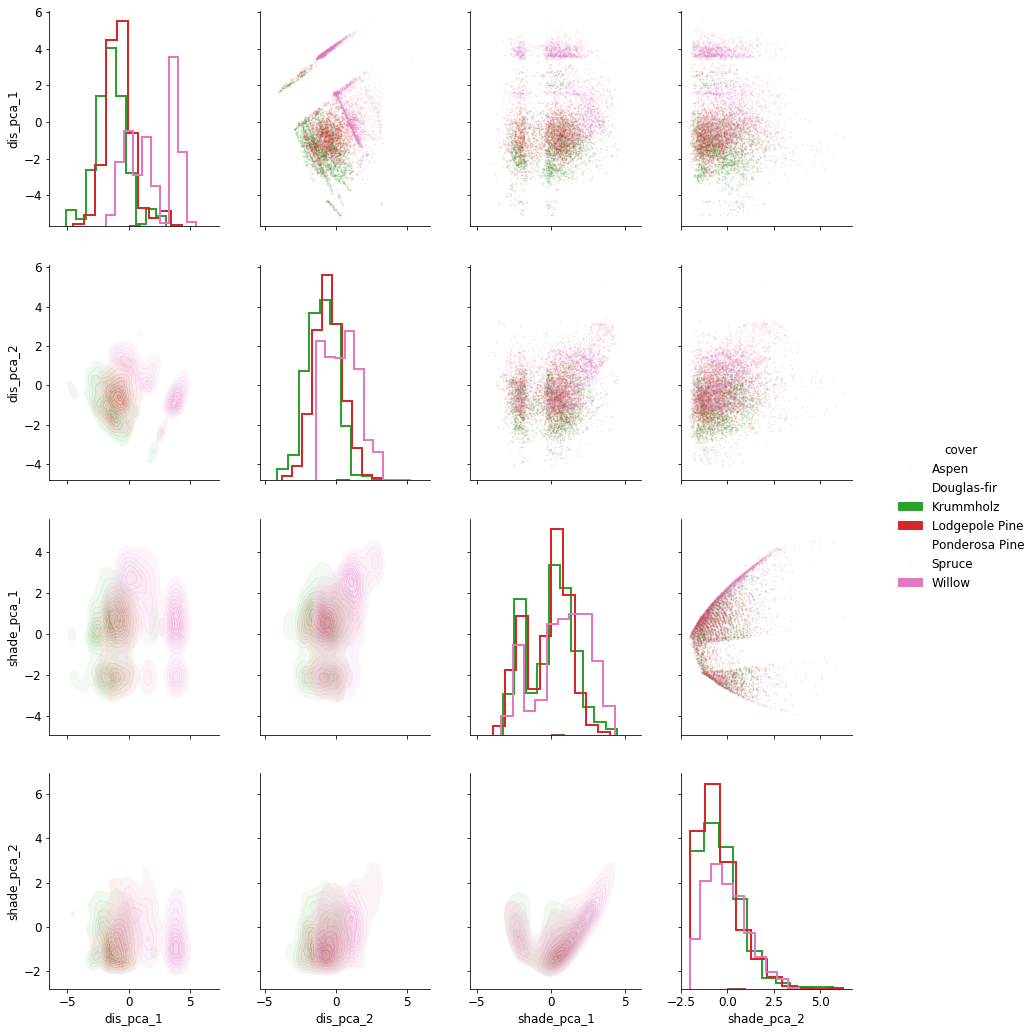

In [39]:
after_pca_charts = after_pca[after_pca.cover_type.isin([2,4,7])].copy()
g = sns.PairGrid(after_pca_charts,vars=['dis_pca_1','dis_pca_2','shade_pca_1','shade_pca_2'],
                 hue="cover",diag_sharey=False)
g.map_upper(plt.scatter,alpha=0.1, s=1)

g.map_lower(sns.kdeplot,alpha=0.3,shade=True, shade_lowest=False)
g = g.map_diag(plt.hist, histtype="step", linewidth=2)

g.add_legend();
g.fig.set_size_inches(15,15)

In [40]:
for_pca.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,combine_cos_cos,Horizontal_Distance_To_Roadways_log,Horizontal_Distance_To_Fire_Points_log,Horizontal_Distance_To_Hydrology_log,distance_to_hydrology_log,dis_pca_1,dis_pca_2,trig_pca_1,shade_pca_1,shade_pca_2
count,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,...,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,1.512000e+04,15120.000000,15120.000000,1.512000e+04,1.512000e+04
mean,2749.322553,156.676653,16.501587,227.195701,51.076521,1714.023214,212.704299,218.965608,135.091997,1511.147288,...,0.140546,3.094011,3.065365,2.017552,2.033509,-3.007588e-17,0.000000,0.000000,1.503794e-17,-3.007588e-17
std,417.678187,110.085801,8.453927,210.075296,61.239406,1325.066358,30.561287,22.801966,45.895189,1099.936493,...,0.652556,0.380378,0.337134,0.784278,0.789035,1.654823e+00,1.282158,1.796408,1.786173e+00,1.309752e+00
min,1863.000000,0.000000,0.000000,0.000000,-146.000000,0.000000,0.000000,99.000000,0.000000,0.000000,...,-1.000000,0.000000,0.000000,0.000000,0.000000,-5.104702e+00,-4.112919,-2.840816,-4.423325e+00,-2.033666e+00
25%,2376.000000,65.000000,10.000000,67.000000,5.000000,764.000000,196.000000,207.000000,106.000000,730.000000,...,-0.459472,2.883661,2.863917,1.832509,1.833697,-1.072688e+00,-0.927201,-1.801583,-1.833440e+00,-1.011793e+00
50%,2752.000000,126.000000,15.000000,180.000000,32.000000,1316.000000,220.000000,223.000000,138.000000,1256.000000,...,0.255600,3.119586,3.099335,2.257679,2.277565,-2.201505e-01,-0.045024,0.155707,2.801515e-01,-2.764284e-01
75%,3104.000000,261.000000,22.000000,330.000000,79.000000,2270.000000,235.000000,235.000000,167.000000,1988.250000,...,0.760227,3.356217,3.298689,2.519828,2.535382,7.428963e-01,0.929844,1.613720,1.271201e+00,7.532410e-01
max,3849.000000,360.000000,52.000000,1343.000000,554.000000,6890.000000,254.000000,254.000000,248.000000,6993.000000,...,1.000000,3.838282,3.844726,3.128399,3.132880,5.658963e+00,6.061131,3.930400,4.547598e+00,7.070449e+00


Text(0.5,0,'')

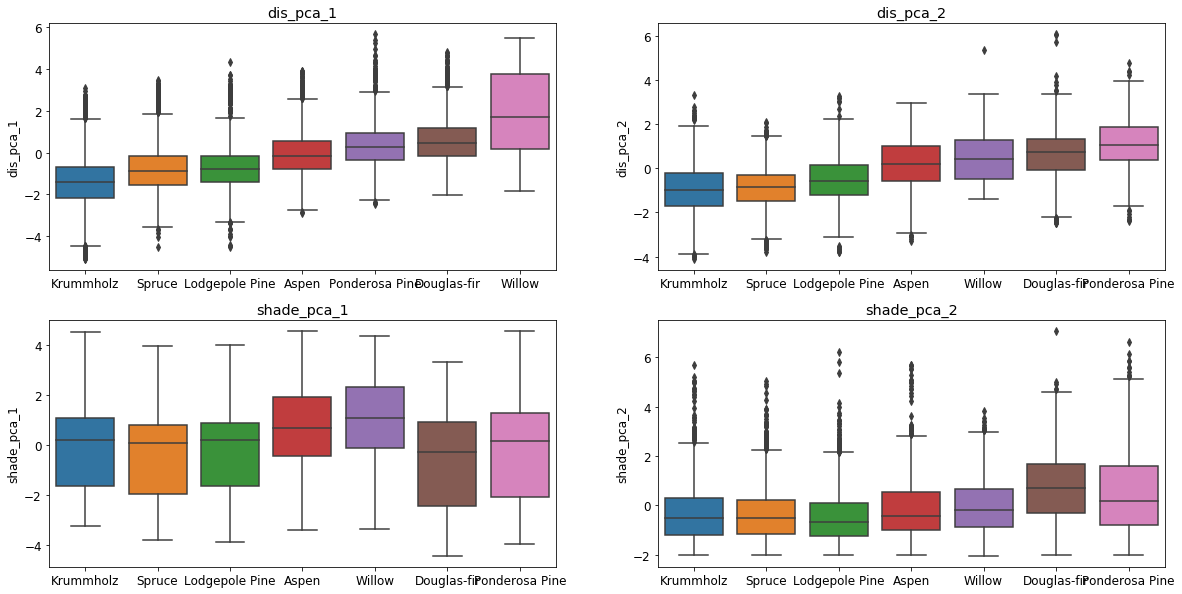

In [42]:
f, axes = plt.subplots(2, 2, figsize=(20, 10))
for_pca["Cover_Type"] = train.Cover_Type
for_pca["Cover"] = train.Cover

#sns.distplot(train.Elevation, kde=False, color="b", ax=axes[0]);
order_label = [covert[i] for i in [7,1,2,5,3,6,4]]

sns.boxplot(x="Cover", y="dis_pca_1", data=for_pca,ax=axes[0][0],order=order_label);
axes[0][0].set_title("dis_pca_1")
axes[0][0].axes.set_xlabel("")
order_label = [covert[i] for i in [7,1,2,5,4,6,3]]
sns.boxplot(x="Cover", y="dis_pca_2", data=for_pca,ax=axes[0][1],order=order_label)
axes[0][1].set_title("dis_pca_2")
axes[0][1].axes.set_xlabel("")

order_label = [covert[i] for i in [7,1,2,5,4,6,3]]
sns.boxplot(x="Cover", y="shade_pca_1", data=for_pca,ax=axes[1][0],order=order_label)
axes[1][0].set_title("shade_pca_1")
axes[1][0].axes.set_xlabel("")

order_label = [covert[i] for i in [7,1,2,5,4,6,3]]
sns.boxplot(x="Cover", y="shade_pca_2", data=for_pca,ax=axes[1][1],order=order_label)
axes[1][1].set_title("shade_pca_2")
axes[1][1].axes.set_xlabel("")




Text(0.5,1,'Horizontal_Distance_To_Fire_Points')

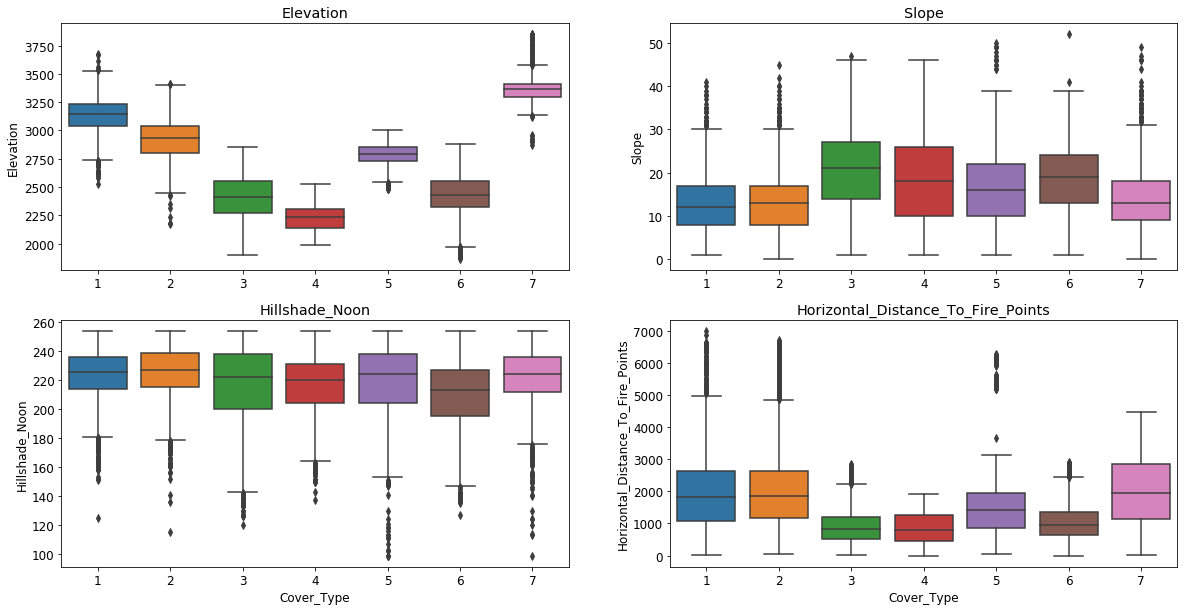

In [227]:
f, axes = plt.subplots(2, 2, figsize=(20, 10))
for_pca["Cover_Type"] = train.Cover_Type
#sns.distplot(train.Elevation, kde=False, color="b", ax=axes[0]);
sns.boxplot(x="Cover_Type", y="Elevation", data=for_pca,ax=axes[0][0]);
axes[0][0].set_title("Elevation")
axes[0][0].axes.set_xlabel("")
sns.boxplot(x="Cover_Type", y="Slope", data=for_pca,ax=axes[0][1])
axes[0][1].set_title("Slope")
axes[0][1].axes.set_xlabel("")


sns.boxplot(x="Cover_Type", y="Hillshade_Noon", data=for_pca,ax=axes[1][0])
axes[1][0].set_title("Hillshade_Noon")

sns.boxplot(x="Cover_Type", y="Horizontal_Distance_To_Fire_Points", data=for_pca,ax=axes[1][1])
axes[1][1].set_title("Horizontal_Distance_To_Fire_Points")

